In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **SUL DATASET**

Il dataset è una versione pre-processata del dataset **OASIS Alzheimer's Detection** (un dataset di immagini MRI del cervello di 461 pazienti) utilizzato per rilevare i segni precoci dell’Alzheimer.

Poiché le immagini MRI sono 3D, sono state divise lungo l'asse z (l'asse della profondità del cervello) in 175 fette e sono state selezionate le fette che vanno dalla 55 esima alla 124 esima al fine di ridurre il numero di immagini e concentrarsi sulle sezioni cerebrali rilevanti per l'analisi della demenza; Questo approccio ha generato immagini 2D per ogni paziente.

Lo stesso approccio è stato utilizzato per le versioni delle MRI con segmentazione delle aree cerebrali offerte da OASIS.

****
****

Le immagini sono classificate in **quattro sottoclassi**, in base alla progressione della malattia:

*   Moderate dementia (affetto da demenza)

*   Very mild dementia (affetto da demenza molto lieve)
* Mild dementia (affetto da demenza lieve)
* Non-demented (non affetto da demenza)


*La classificazione dei pazienti è stata effettuata sulla base delle valutazioni CDR (Clinical Dementia Rating), un punteggio che valuta la severità della demenza.*



In [ ]:
#estrazione dataset
import zipfile
import os

zip_path = "/content/drive/My Drive/Alzheimer-detection-project/oasis 1.zip"
extract_folder = "/content/Alzheimer-detection-project"

os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("File estratti:", os.listdir(extract_folder))


File estratti: ['__MACOSX', 'oasis 1']


In [ ]:
oasis1_path = os.path.join(extract_folder, "oasis 1")
categories = ['Moderate Dementia', 'Mild Dementia', 'Very Mild Dementia', 'Non Demented']
for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_segmented_path=os.path.join(category_path, 'mri segmented')
    mri_path= os.path.join(category_path, 'mri scan')

In [ ]:
import os

for dirpath, dirnames, filenames in os.walk(oasis1_path):
    for filename in filenames:
        if filename == ".DS_Store":
            file_path = os.path.join(dirpath, filename)
            os.remove(file_path)
            print(f"Rimosso: {file_path}")


Rimosso: /content/Alzheimer-detection-project/oasis 1/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Mild Dementia/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Mild Dementia/mri scan/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Mild Dementia/mri segmented/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Moderate Dementia/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Moderate Dementia/mri scan/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Moderate Dementia/mri segmented/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Non Demented/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Non Demented/mri scan/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Non Demented/mri scan/OAS1_0002MR1/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Non Demented/mri scan/OAS1_0050MR1/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oas

Moderate Dementia: 140 immagini mri segmentate
Mild Dementia: 1960 immagini mri segmentate
Very Mild Dementia: 5006 immagini mri segmentate
Non Demented: 23520 immagini mri segmentate
Moderate Dementia: 140 immagini mri 
Mild Dementia: 1960 immagini mri 
Very Mild Dementia: 5006 immagini mri 
Non Demented: 23520 immagini mri 


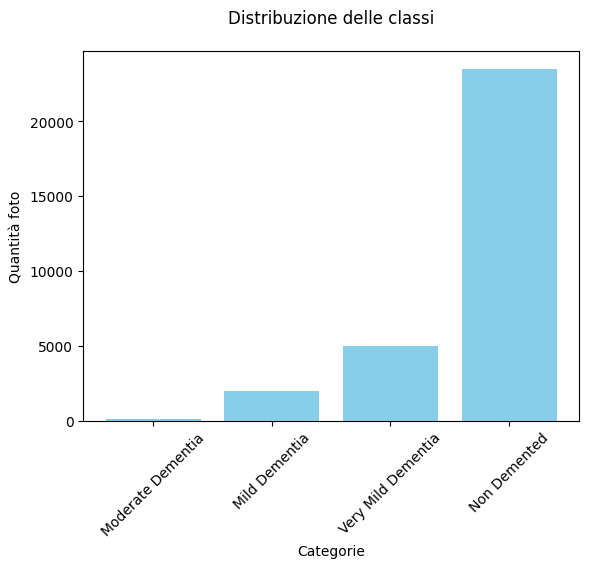

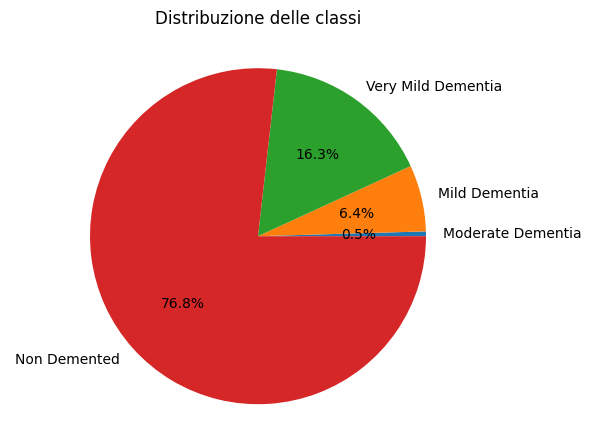

In [ ]:
# numero di immagini per categoria - grafico di distriibuzione delle classi
import matplotlib.pyplot as plt

somma=0

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_segmented_path=os.path.join(category_path, 'mri segmented')
    for patient in os.listdir(mri_segmented_path):
      images= os.listdir(os.path.join(mri_segmented_path, patient))
      somma=somma+len(images)
    print(f"{category}: {somma} immagini mri segmentate")
    somma=0

valori=[]

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      images= os.listdir(os.path.join(mri_path, patient))
      somma=somma+len(images)
    print(f"{category}: {somma} immagini mri ")
    valori.append(somma)
    somma=0

# visualizzazione tramite istogramma
plt.bar(categories, valori, color='skyblue')
plt.title('Distribuzione delle classi', pad=20)
plt.xlabel('Categorie')
plt.xticks(rotation=45)
plt.ylabel('Quantità foto')
plt.show()

print(f" ")
# visualizzazione tramite grafico a torta
plt.pie(valori, labels=categories, autopct='%1.1f%%', startangle=0)
plt.title('Distribuzione delle classi',pad=20)
plt.axis('equal')
plt.show()




OAS1_0308MR1: paziente 
OAS1_0308MR1 seg: paziente segmentato


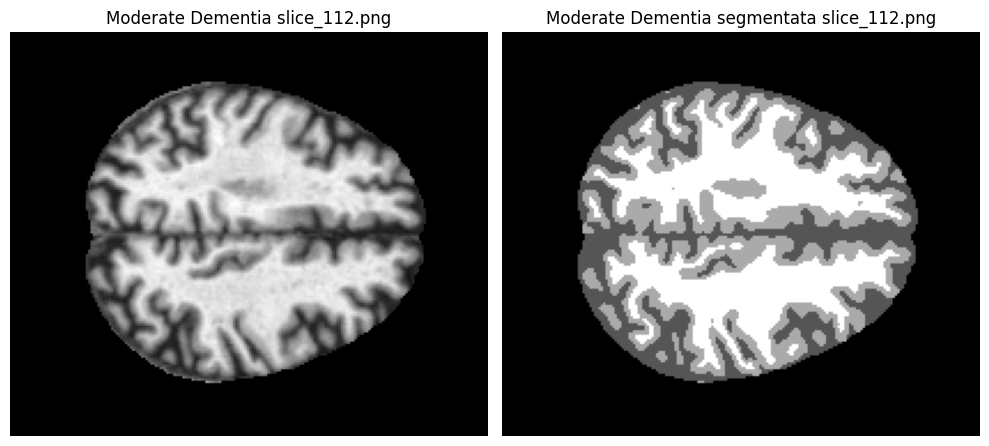

OAS1_0425MR1: paziente 
OAS1_0425MR1 seg: paziente segmentato


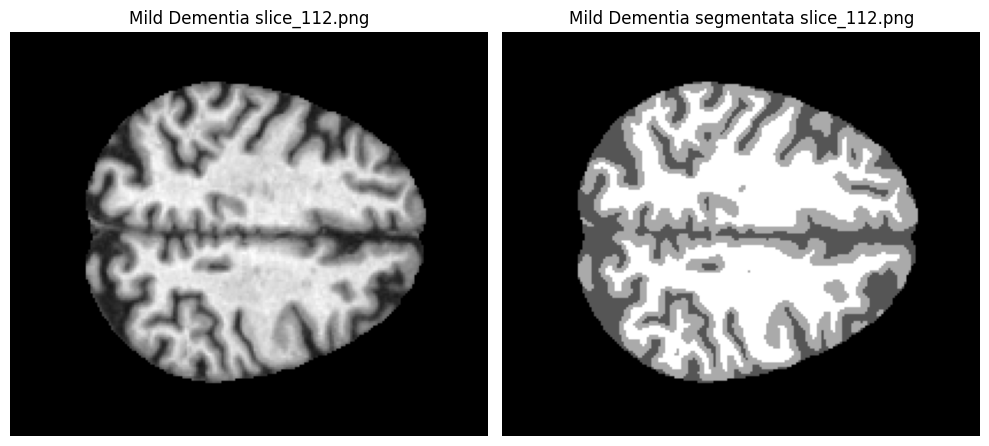

OAS1_0022MR1: paziente 
OAS1_0022MR1 seg: paziente segmentato


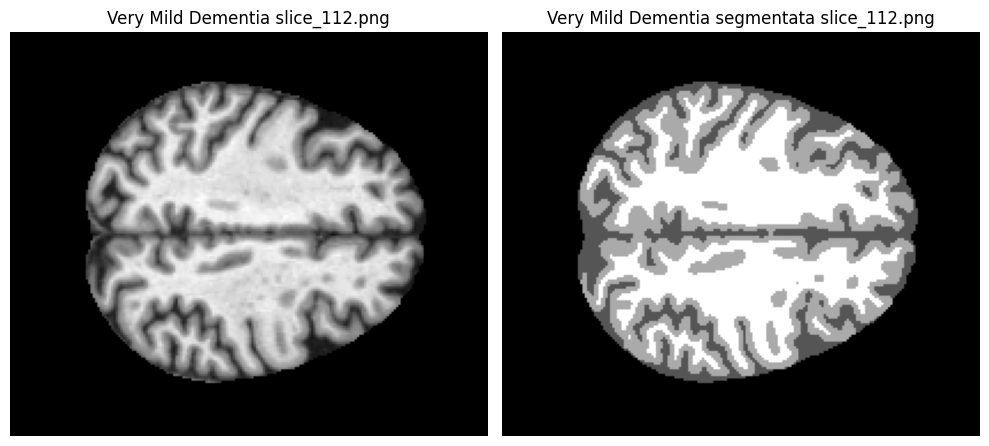

OAS1_0136MR1: paziente 
OAS1_0136MR1 seg: paziente segmentato


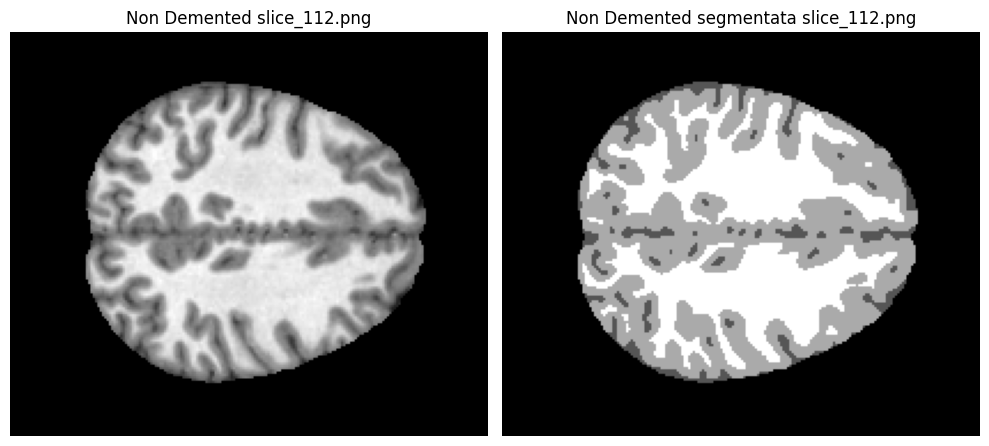

In [ ]:
#visualizzazione di immagini a campione

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

#scelta della slice
folders=os.listdir(mri_path)
random_folder = random.choice(folders)
patient_path= os.path.join(mri_path, random_folder)
random_slice = random.choice(os.listdir(patient_path))


for category in categories:
  category_path = os.path.join(oasis1_path, category)
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  mri_path= os.path.join(category_path, 'mri scan')
  folders=os.listdir(mri_path)
  random_folder = random.choice(folders)
  print(f"{random_folder}: paziente ")
  random_folder_seg= f"{random_folder.strip()} seg"
  print(f"{random_folder_seg}: paziente segmentato")

  patient_path= os.path.join(mri_path, random_folder)
  patient_path_seg= os.path.join(mri_segmented_path, random_folder_seg)

  img_path = os.path.join(patient_path, random_slice)
  img = mpimg.imread(img_path)
  img_seg_path = os.path.join(patient_path_seg, random_slice)
  img_seg = mpimg.imread(img_seg_path)

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(img)
  axes[0].set_title(f"{category} {random_slice}")
  axes[0].axis('off')

  axes[1].imshow(img_seg)
  axes[1].set_title(f"{category} segmentata {random_slice}")
  axes[1].axis('off')

  plt.tight_layout()
  plt.show()




In [ ]:
# check dimensioni e canali

images_dimentions=set()
images_channels=set()

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      patient_path=os.path.join(mri_path, patient)
      file_path=os.path.join(patient_path, '.DS_Store')
      if os.path.isfile(file_path):
        os.remove(file_path)
      images= os.listdir(os.path.join(mri_path, patient))

      for image in images:
        image_path=os.path.join(patient_path, image)
        i = mpimg.imread(image_path)
        w, h = i.shape[:2]
        images_dimentions.add((w, h))

        if len(i.shape) == 3:
          channels = i.shape[2]
        else:
          channels = 1
        images_channels.add(channels)

if len(images_dimentions) == 1:
  print("tutte le immagini hanno le stesse dimensioni", images_dimentions.pop())
else:
  print("NON tutte le immagini hanno le stesse dimensioni:")
  for dim in images_dimentions:
        print(" ", dim)

if len(images_channels) == 1:
    print("tutte le immagini hanno lo stesso numero di canali:", images_channels.pop())
else:
    print("NON tutte le immagini hanno lo stesso numero di canali:")
    for ch in images_channels:
        print(" ", ch)



tutte le immagini hanno le stesse dimensioni (176, 208)
tutte le immagini hanno lo stesso numero di canali: 4


In [ ]:
# conversione delle immagini in scale di grigi
# utilizzo Grayscale = 0.299 * R + 0.587 * G + 0.114 * B

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
        patient_path = os.path.join(mri_path, patient)
        file_path = os.path.join(patient_path, '.DS_Store')
        if os.path.isfile(file_path):
            os.remove(file_path)
        images = os.listdir(os.path.join(mri_path, patient))

        for image in images:
            image_path = os.path.join(patient_path, image)
            i = mpimg.imread(image_path)

            if len(i.shape) == 3 and i.shape[2] >= 3:
                i_rgb = i[..., :3]

                i_gray = 0.299 * i_rgb[..., 0] + 0.587 * i_rgb[..., 1] + 0.114 * i_rgb[..., 2]
                i_gray = (i_gray * 255).astype(np.uint8)
                gray_img = Image.fromarray(i_gray)
                gray_img.save(image_path)

# check del nuovo numero di canali
images_channels=set()
for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      patient_path=os.path.join(mri_path, patient)
      images= os.listdir(os.path.join(mri_path, patient))

      for image in images:
        image_path=os.path.join(patient_path, image)
        i = mpimg.imread(image_path)

        if len(i.shape) == 3:
          channels = i.shape[2]
        else:
          channels = 1
        images_channels.add(channels)

if len(images_channels) == 1:
    print("tutte le immagini hanno lo stesso numero di canali:", images_channels.pop())
else:
    print("NON tutte le immagini hanno lo stesso numero di canali:")
    for ch in images_channels:
        print(" ", ch)

tutte le immagini hanno lo stesso numero di canali: 1


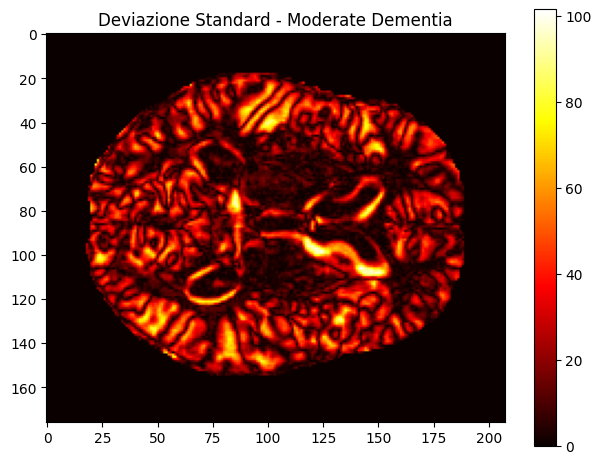

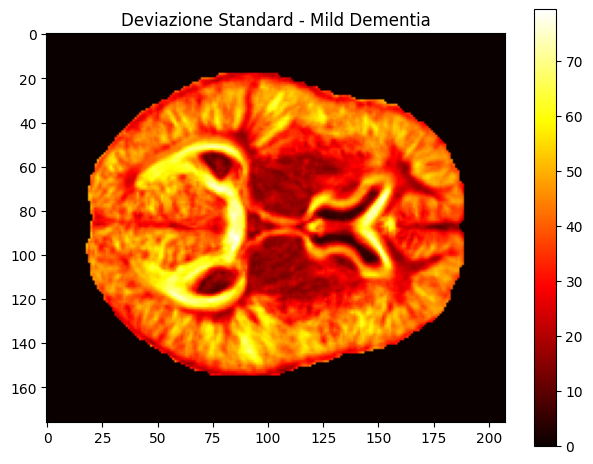

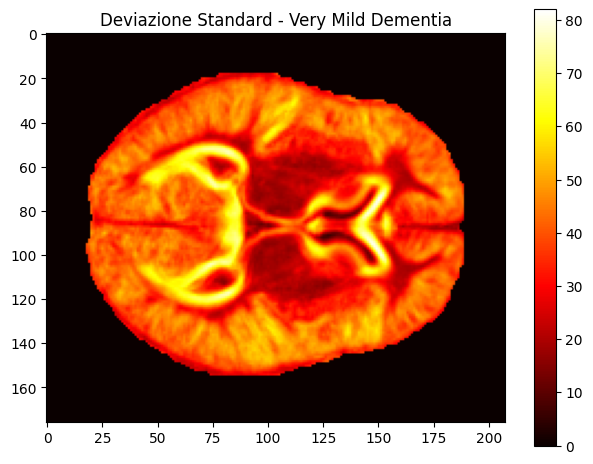

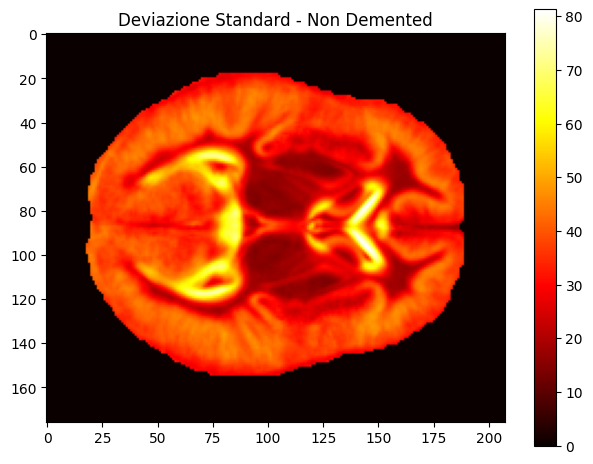

In [27]:
# calcolo della variazione standard tra le slice per categoria
std= {}

for name in images:
  for category in categories:
    slices = []
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      patient_path=os.path.join(mri_path, patient)
      slice_of_interest= os.path.join(patient_path, name)
      i = Image.open(slice_of_interest)
      i_array = np.array(i)
      slices.append(i_array)

    if slices:
        all_slices_stack = np.stack(slices)
        std_map = np.std(all_slices_stack, axis=0)
        std[category] = std_map

for category, std_map in std.items():
  im = plt.imshow(std_map, cmap='hot')
  plt.title(f"Deviazione Standard - {category}")
  plt.colorbar(im)
  plt.tight_layout()
  plt.show()

In [ ]:
# etichette immagini segmentate

